In [99]:
import sys
sys.path.insert(0, 'Resources/MagicCube/code/')
import matplotlib.pyplot as plt
import random as rd
from bitstring import BitArray
import math

from cube import *
from utils import *

From around 4. 10¹⁹ states if we took all the configurations of the cube, we consider the 2**26 that represent: 
- Is a face done, for each face (2**6 states)
- Is an edge done (2**12 states)
- Is a corner done (2**8 states)

It may be not even sufficient in order to implement Q-learning (too many states)


Update: it is indeed too big (Memory Error). We try now 12.6.8 (nb faces done, nb edges done, nb corners done)

In [138]:
N = 3 #cube size

#Q-learning parameters
r = 0
gamma = 1 / (1 + r) #discount of the model
C = 1.
epsilon = 0.15
beta = 3./4 

In [94]:
def all_actions(N): #rotate by +90° / by -90° 
    actions = []
    c = Cube(N)
    for face_name in list(Cube.facedict.keys())[:3]: #the list is in the end ['U','D','F']
        for layer in range(c.N):
            for times in [1,-1]:
                actions.append([face_name,layer,times])
    return actions

def reward_cube(c):
    edges = computeEdges(c)
    corners = computeCorners(c)
    ncf = numCompleteFaces(c)
    nce = numCompleteEdges(c,edges)
    ncc = numCompleteCorners(c,corners)
    
    return 2*nce + 3*ncc + 100*ncf

def state_cube(c):
    #determining the new state
    edges = computeEdges(c)
    corners = computeCorners(c)
#     edges_state = []
#     corners_state = []
#     faces_state = []
#     for e in edges:
#         edges_state.append(e.isDone(c))
#     for corner in corners:
#         corners_state.append(corner.isDone(c))
#     nFaces = 6
#     for f in range(nFaces):
#         faces_state.append(np.sum(c.stickers[f] != c.stickers[f,0,0]) == 0)
#     #conversion from binary list to int
#     e = BitArray(edges_state).uint
#     c = BitArray(corners_state).uint
#     f = BitArray(faces_state).uint
    ncf = numCompleteFaces(c)
    nce = numCompleteEdges(c,edges)
    ncc = numCompleteCorners(c,corners)
    return ncf,nce,ncc

def test_function_state_cube():
    c = Cube(3)
    print(state_cube(c))
    c.randomize(1)
    print(state_cube(c))

In [142]:
def Q_learning(c_init,Tmax,nb_episodes):
    actions = all_actions(c_init.N) #rotate by +90° / by -90° 
    nb_actions = len(actions)
    
    Q_t = np.ones([6+1, 12+1, 8+1, nb_actions]) #face,edge,corner,action
    N = np.zeros(Q_t.shape)
    alpha = lambda n: min(1, C / math.pow(n,beta))
    list_cumulated_reward = []
    
    for episode in range(nb_episodes):
        c = copy.deepcopy(c_init)
        c.randomize(200) #we randomize 200 times in order to have a "well mixed" cube
        cumulated_reward = 0
        for i in range(Tmax):
            
            ncf,nce,ncc = state_cube(c)
            
            #transition           
            if(rd.random() > epsilon):
                index_action = np.argmax(Q_t[ncf,nce,ncc])
            else:
                index_action = rd.randint(0,nb_actions-1)
            a_t = index_action
            f,l,d = actions[a_t]
            c.move(f,l,d)            
            R_t = reward_cube(c)
            
            #determining the new state
            ncf_new,nce_new,ncc_new = state_cube(c)
            
            #updates
            N[ncf,nce,ncc,a_t] = N[ncf,nce,ncc,a_t] + 1
            Q_t[ncf,nce,ncc,a_t] = (1 - alpha(N[ncf,nce,ncc,a_t])) * Q_t[ncf,nce,ncc,a_t] + \
                    alpha(N[ncf,nce,ncc,a_t]) * (R_t + gamma * max(Q_t[ncf_new,nce_new,ncc_new]))
            cumulated_reward += R_t
    
        list_cumulated_reward.append(cumulated_reward)
    
    return N,Q_t,list_cumulated_reward

In [143]:
N,Q_learned,list_cumulated_reward = Q_learning(c_init=Cube(3),Tmax=100,nb_episodes=100)

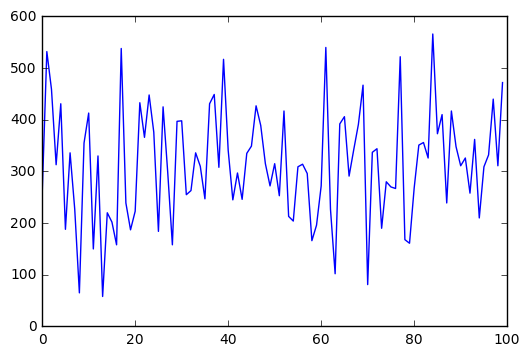

In [144]:
plt.plot(list_cumulated_reward)
plt.show()